## Example of Jupyter/Ginga widget

This is an example of creating a Jupyter data viewer widget using a ipywidgets image
widget and the Ginga viewer toolkit.

### *NOTE*: To use these examples, you need to install the `ipywidgets` with the `ipyevents` package:

`$ pip install ipywidgets ipyevents`

`$ jupyter nbextension install --py --sys-prefix ipyevents`

`$ jupyter nbextension enable --py --sys-prefix ipyevents`

See https://github.com/mwcraig/ipyevents for JupyterLab installation instructions.

In [1]:
# some imports needed to make viewer controls
from ginga import cmap
cmap.add_matplotlib_cmaps(fail_on_import_error=False)
from ginga import ColorDist

In [2]:
# create a Jupyter image that will be our display surface
# format can be 'jpeg' or 'png'; specify width and height to set viewer size
# PNG will be a little clearer, especially with overlaid graphics, but
# JPEG is faster to update
import ipywidgets as widgets
jup_img = widgets.Image(format='png', width=500, height=500)

In [3]:
# Boilerplate to create a Ginga viewer connected to this widget
# this could be simplified, or hidden behind a class or convenience 
# method
# NOTE: you don't have to specify a log file--and if you are not interested
# in the log just specify null=True for a null logger
# level=10 will give you the most debugging information
from ginga.misc.log import get_logger
logger = get_logger("my viewer", log_stderr=False, log_file='/tmp/ginga.log', level=40)

from ginga.web.jupyterw.ImageViewJpw import EnhancedCanvasView
v1 = EnhancedCanvasView(logger=logger)
# set our linkage between the jupyter widget at ginga
v1.set_widget(jup_img)

# enable all possible keyboard and pointer operations
bd = v1.get_bindings()
bd.enable_all(True)
# if you want to be able to see what keyboard enabled modes
# you have entered
v1.show_mode_indicator(True)

In [4]:
coordinates = widgets.HTML('<h3>coordinates show up here</h3>')

# callback to display position in RA/DEC deg
def mouse_move(viewer, button, data_x, data_y, w):
    image = viewer.get_image()
    if image is not None:
        ra, dec = image.pixtoradec(data_x, data_y)
        w.value = "cursor at %f, %f" % (ra, dec)

v1.add_callback('cursor-changed', mouse_move, coordinates)


In [5]:
%%javascript
/* some magic to keep the cell contents from scrolling
   (when we embed the viewer)
   NOTE: this won't work if you have notebook version >= 7
   or most in JupyterLab.
   (you will see "Javascript Error: IPython is not defined")
  In that case, see the instructions
   where we embed the viewer widgets below.
 */
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

NOTE: these next few cells define functions that will make a widget for controlling a viewer.
Normally, you would just make a module with all of these (customized to how you want) and
import it above.

In [6]:
def make_zoom_control(viewer):
    """set up a zoom control for a ginga-backed Jupyter widget
    NOTE: it would also be possible to set a control for the exact scale, if that is preferred
    """
    zoom_setting = viewer.get_settings().get_setting('zoomlevel')

    # get the current value of the widget and set the control
    zoomlevel = zoom_setting.value
    zoom_ctl = widgets.FloatSlider(value=zoomlevel, orientation='horizontal',
                                   description="Zoom level:", min=-20.0, max=20.0, step=0.1)
    
    # this callback gets called when the zoom slider is moved
    am_zooming = False
    def on_zoom_slider(dct):  # see ipywidgets API for details of the observe() callback
        global am_zooming
        try:
            am_zooming = True
            viewer.zoom_to(dct['new'])
        finally:
            am_zooming = False
    
    # link changes in the widget to the slider, so that if we change the scale/zoom via the 
    # Ginga API, the control will change to match
    def on_zoom_widget(setting, value):
        global am_zooming
        if not am_zooming:
            zoom_ctl.value = value
    
    zoom_setting.add_callback('set', on_zoom_widget)
    zoom_ctl.observe(on_zoom_slider, names='value')
    return zoom_ctl

In [7]:
def make_cmap_control(viewer):
    """Set up a color map drop down
    """
    cmap_setting = viewer.get_settings().get_setting('color_map')
    colormap_names = cmap.get_names()
    cmap_ctl = widgets.Dropdown(options=colormap_names, description="Color map:",
                                value=cmap_setting.value)
 
    def on_cmap_dropdown(dct):
        viewer.set_color_map(dct['new'])
    
    def on_cmap_widget(setting, value):
        cmap_ctl.value = value
    
    cmap_setting.add_callback('set', on_cmap_widget)
    cmap_ctl.observe(on_cmap_dropdown, names='value')
    return cmap_ctl

In [8]:
def make_cdist_control(viewer):
    """ Set up a color distribution drop down
    """
    cdist_setting = viewer.get_settings().get_setting('color_algorithm')
    cdist_names = ColorDist.get_dist_names()

    cdist_ctl = widgets.Dropdown(options=cdist_names, description="Dist Alg:",
                                 value=cdist_setting.value)

    def on_cdist_dropdown(dct):
        viewer.set_color_algorithm(dct['new'])
    
    def on_cdist_widget(setting, value):
        cdist_ctl.value = value
    
    cdist_setting.add_callback('set', on_cdist_widget)
    cdist_ctl.observe(on_cdist_dropdown, names='value')
    return cdist_ctl

In [9]:
def make_contrast_control(viewer):
    """Set up a contrast control.
    """
    contrast_setting = viewer.get_settings().get_setting('contrast')
    contrast_ctl = widgets.FloatSlider(orientation='horizontal',
                                       description="Contrast:", value=contrast_setting.value,
                                       min=0.0, max=1.0, step=0.01)

    # this callback gets called when the contrast slider is moved
    am_contrasting = False
    def on_contrast_slider(dct):
        global am_contrasting
        try:
            am_contrasting = True
            viewer.set_contrast(dct['new'])
        finally:
            am_contrasting = False
    
    # link changes in the widget to the slider
    def on_contrast_widget(setting, value):
        global am_contrasting
        if not am_contrasting:
            contrast_ctl.value = value
    
    contrast_setting.add_callback('set', on_contrast_widget)
    contrast_ctl.observe(on_contrast_slider, names='value')
    return contrast_ctl

In [10]:
def make_brightness_control(viewer):
    """Set up a brightness control
    """
    brightness_setting = viewer.get_settings().get_setting('brightness')
    brightness_ctl = widgets.FloatSlider(orientation='horizontal',
                                         value=brightness_setting.value, 
                                         description="Bias:", min=0.0, max=1.0, step=0.01)

    # this callback gets called when the brightness slider is moved
    am_biasing = False
    def on_brightness_slider(dct):
        global am_biasing
        try:
            am_biasing = True
            viewer.set_brightness(dct['new'])
        finally:
            am_biasing = False
    
    # link changes in the widget to the slider
    def on_brightness_widget(setting, value):
        global am_biasing
        if not am_biasing:
            brightness_ctl.value = value
    
    brightness_setting.add_callback('set', on_brightness_widget)
    brightness_ctl.observe(on_brightness_slider, names='value')
    return brightness_ctl

In [11]:
def make_cut_levels_controls(viewer):
    """Create cut levels controls
    """
    cuts_setting = viewer.get_settings().get_setting('cuts')
    loval, hival = cuts_setting.value
    locut_ctl = widgets.FloatText(value=loval, description="Lo cut:")
    hicut_ctl = widgets.FloatText(value=hival, description="Hi cut:")

    def on_locut_ctl_change(dct):
        lo, hi = viewer.get_cut_levels()
        v1.cut_levels(dct['new'], hi)
    
    def on_hicut_ctl_change(dct):
        lo, hi = v1.get_cut_levels()
        viewer.cut_levels(lo, dct['new'])

    def on_levels_widget(setting, value):
        lo, hi = value
        locut_ctl.value = lo
        hicut_ctl.value = hi
    
    cuts_setting.add_callback('set', on_levels_widget)
    locut_ctl.observe(on_locut_ctl_change, names='value')
    hicut_ctl.observe(on_hicut_ctl_change, names='value')
    return locut_ctl, hicut_ctl

In [12]:
def make_autocut_control(viewer):
    """Create autocut levels control
    """
    autocuts = widgets.Button(description="Auto cuts")
    
    def on_autocuts_click(btn):
        viewer.auto_levels()
        
    autocuts.on_click(on_autocuts_click)
    return autocuts

In [13]:
def make_mode_control(viewer):
    """Create a mode control for allowing in-viewer key and mouse activity
    """
    options = ['none', 'pan', 'zoom', 'cuts', 'contrast']
    mode_control = widgets.RadioButtons(options=options, description="Mode:")
    
    def on_mode_ctl_change(dct):
        bd = viewer.get_bindings()
        mode = dct['new']
        if mode == 'none':
            mode = None
        bd.set_mode(viewer, mode, mode_type='locked')
        
    def on_mode_change_widget(bm, mode, mode_type):
        mode_control.value = mode
        
    viewer.get_bindmap().add_callback('mode-set', on_mode_change_widget)
    mode_control.observe(on_mode_ctl_change, names='value')
    return mode_control

In [14]:
# embed the viewer here
# NOTE: when subsequent cells say to interact with the viewer/image, they mean THIS image!!
#  (NOT screenshots captured by v1.show())
# NOTE: if the output cell is showing a scrolled view, right click in empty space in the cell
#  and from the context menu select "Disable Scrolling for Outputs")
zoom_ctl = make_zoom_control(v1)
cmap_ctl = make_cmap_control(v1)
cdist_ctl = make_cdist_control(v1)
contrast_ctl = make_contrast_control(v1)
brightness_ctl = make_brightness_control(v1)
locut_ctl, hicut_ctl = make_cut_levels_controls(v1)
autocuts_ctl = make_autocut_control(v1)
mode_ctl = make_mode_control(v1)

widgets.HBox([
    widgets.VBox([jup_img, coordinates]),
    widgets.VBox([zoom_ctl, cmap_ctl, cdist_ctl,
                 contrast_ctl, brightness_ctl,
                 locut_ctl, hicut_ctl,
                 autocuts_ctl, mode_ctl]),
])

In [15]:
# Load a FITS file.  You should see the embedded image update.
v1.load_fits("/path/to/some/fits/SUPA01118766.fits")

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set DATE-END to '2009-08-22T09:35:55.248' from MJD-END'. [astropy.wcs.wcs]
  'degree' -> 'deg',
  'degree' -> 'deg'. [astropy.wcs.wcs]


You can now do nearly everything that can be done with a ginga viewer widget.
See http://ginga.readthedocs.io/en/latest/quickref.html for default key and button/pointer bindings.

See https://github.com/ejeschke/ginga/blob/main/ginga/examples/jupyter-notebook/ginga_ipython_demo.ipynb
for the kinds of things you can do with the embedded viewer including graphics overplotting, etc.

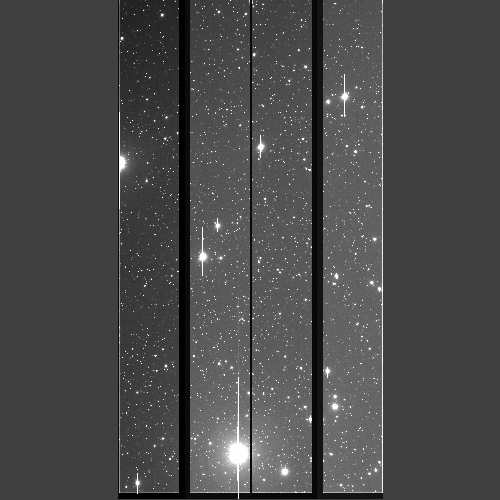

In [16]:
# grab a screenshot.
v1.show()

In [17]:
# add a canvas to the image and set the draw type
canvas = v1.add_canvas()
canvas.set_drawtype('ellipse', color='orange', fill=True, fillcolor='cyan', fillalpha=0.3)
# this let's us draw with the left mouse button or touchpad
canvas.register_for_cursor_drawing(v1)

Now make sure you have exited all modes by pressing "Esc" or clicking "none" for the mode (modes take precedence over canvas operations).
Draw the shape using the left mouse button or touchpad.

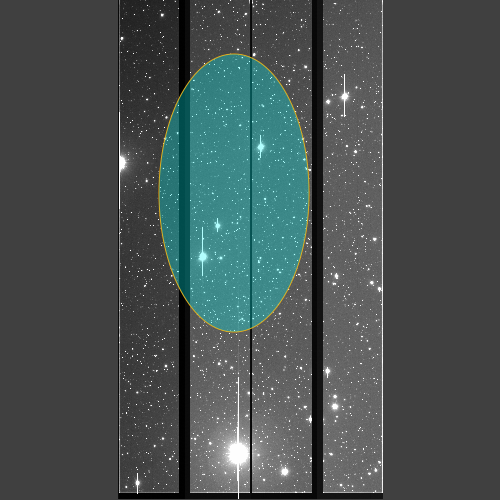

In [18]:
v1.show()

In [19]:
# put the canvas in edit mode
canvas.enable_edit(True)
canvas.set_draw_mode('edit')

Now you can click on the object to select it and edit it.  Editing control points should appear:
- orange: stretch or shrink dimension(s)
- green: scale object while keeping aspect
- blue: rotate object
- red: move object
You can also move objects simply by dragging anywhere in the bounding box if they are selected.

In [20]:
canvas.get_objects()

In [21]:
# let's get the object that we drew--what is it's location?
ell = canvas.get_objects()[0]
ell.x, ell.y

(1058.5860000000002, 2520.57)

In [22]:
ell.xradius, ell.yradius

(487.12199999999996, 995.488633802817)

In [23]:
# delete everything on the canvas that we drew
canvas.set_draw_mode('draw')
canvas.delete_all_objects()

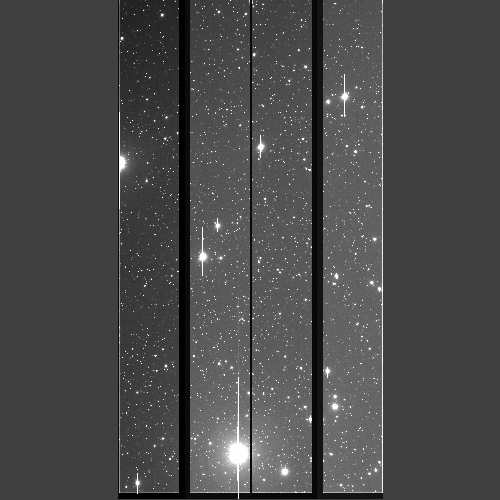

In [24]:
v1.show()